# Generating images using DCGAN
Sequel to the [first notebook](https://github.com/jppgks/shenanigan/blob/master/1.%20generating-samples-from-1D-gaussian.ipynb) on generating samples from a 1-D Gaussian. In this notebook, we'll cherry-pick from existing deep convolutional GAN implementations to generate images.

This one builds on https://bamos.github.io/2016/08/09/deep-completion/#ml-heavy-generative-adversarial-net-gan-building-blocks (The MIT License (MIT), Copyright (c) 2013 Brandon Amos <http://bamos.github.io>) and cherry-picked network setup from https://github.com/tensorflow/models/blob/master/research/gan/tutorial.ipynb (Copyright 2017 The TensorFlow Authors, Apache License, Version 2.0).

## Development environment
Let's start with setting up our development environment by loading the necessary libraries.

Instead of standard TensorFlow, we will use the recently released "eager execution". This provides define-by-run access to most of the standard TensorFlow API. Details about eager execution can be found in this Google Research blog post [link text](https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html).

At the time of writing, the latest stable release of TensorFlow is 1.4.1 which does not include the eager functionality. Therefore, we install the nightly build before continuing.

In [0]:
! pip uninstall -yq tensorflow
! pip uninstall -yq tf-nightly
! pip install -Uq tf-nightly

Cannot uninstall requirement tf-nightly, not installed


We first import TensorFlow as usual and then import `tensorflow.contrib.eager` and enable eager execution.

The other dependencies for this notebook are NumPy and some packages for plotting.

In [0]:
# Import TensorFlow
import tensorflow as tf
print("Running TensorFlow version " + tf.VERSION)
# Define by run (https://research.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

# Import GAN module as alias
import tensorflow.contrib.gan as tfgan 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython import display
%matplotlib inline

Running TensorFlow version 1.6.0-dev20180105


In [0]:
# Make mnist helpers discoverable
import sys
! git clone https://github.com/tensorflow/models
sys.path.append('models/research/gan')

# Make slim models discoverable
sys.path.append('models/research/slim')

Cloning into 'models'...
remote: Counting objects: 10038, done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 10038 (delta 30), reused 53 (delta 20), pack-reused 9971
Receiving objects: 100% (10038/10038), 313.61 MiB | 42.44 MiB/s, done.
Resolving deltas: 100% (5222/5222), done.


## Defining noise distribution $p_z$ and expected generator behavior
This time, our noise prior $p_z$  is a uniform distribution between -1 and 1. Sampling this distribution is written as $z\sim p_z$.

In [0]:
z = np.random.uniform(-1, 1, 5)
z

array([-0.16682476,  0.14921495,  0.80300683,  0.68030125, -0.07929855])

Now that we have a simple distribution we can easily sample from, we'd like to define our generator $G(z)$ that produces samples from the original probability distribution (images).

```
def G(z): 
  ... 
  
  return imageSample

z = np.random.uniform(-1, 1, 5) 
imageSample = G(z)
```

In order to do so from a lower-dimensional input ($z\sim p_z$), we'll use the transpose of a convolutional layer (the default when dealing with images): **fractionally-strided convolutions** ([A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf), chapter 4). This operations scales its input to a higher dimension. The generator will tweak the parameters involved in such a fractionally-strided convolution layer so the output of this upsampling resembles the target distribution of natural images.

<img src="https://bamos.github.io/data/2016-08-09/gen-architecture.png" height="200px"></img>
> *Generator architecture from [DCGAN paper](https://arxiv.org/abs/1511.06434)*

The discriminator takes an image as input and scales it down to one scalar, representing the probability it came from the data generating distribution $p_{data}$. $D$ will therefore use standard convolution.

## Helpers

In [0]:
def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(images_np):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')

## Data input pipeline

### Load and preprocess data

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

MNIST_DATA_DIR = '/tmp/mnist-data'
batch_size = 32

if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

# Returns training and test tf.data.Dataset objects.
data = input_data.read_data_sets(MNIST_DATA_DIR)

dataset = (tf.data.Dataset
           .from_tensor_slices(data.train.images)
           .map(lambda x: (x - 0.5) / 0.5)
           .shuffle(60000)
           .batch(batch_size))

# Use both train and validation images as real data
#train_ds = tf.data.Dataset.from_tensor_slices(data.train.images)
#val_ds = tf.data.Dataset.from_tensor_slices(data.validation.images)
#train_ds = train_ds.concatenate(val_ds)

# Reshape them into images
#train_ds = train_ds.map(lambda x: tf.image.resize_images(tf.reshape(x, [28, 28, 1]), [64, 64])) 
# and normalize
#train_ds = train_ds.map(lambda x: (x - 0.5) / 0.5) #tf.reshape(x, [28, 28, 1])

# And make batches
#train_ds = train_ds.shuffle(60000).batch(batch_size)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/mnist-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/mnist-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/mnist-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/mnist-data/t10k-labels-idx1-ubyte.gz


Sanity check that our real data batches look like images:

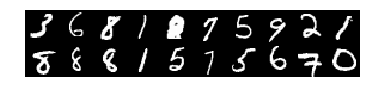

In [0]:
generated_data_to_visualize = tfgan.eval.image_reshaper(
    tf.reshape(tfe.Iterator(dataset).next()[:20], [20, 28, 28, 1]), num_cols=10)
visualize_digits(generated_data_to_visualize)

## Defining generator and discriminator models


### Generator

In [0]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.2)

In [0]:
layers = tf.contrib.layers

class Generator(tfe.Network):
  def __init__(self, data_format):
    super(Generator, self).__init__()
    
    self.data_format = data_format
    # We are using 128 6x6 channels as input to the first deconvolution layer
    if data_format == 'channels_first':
      self._pre_conv_shape = [-1, 128, 6, 6]
    else:
      assert data_format == 'channels_last'
      self._pre_conv_shape = [-1, 6, 6, 128]
    
    self.fc1 = self.track_layer(tf.layers.Dense(6 * 6 * 128,
                                                activation=tf.nn.relu))

    # In call(), we reshape the output of fc1 to _pre_conv_shape

    # Deconvolution layer. Resulting image shape: (batch, 14, 14, 64)
    self.conv1 = self.track_layer(tf.layers.Conv2DTranspose(
        64, 4, strides=2, activation=tf.nn.relu, data_format=data_format))
    #self.conv1_bn = self.track_layer(tf.layers.BatchNormalization())

    # Deconvolution layer. Resulting image shape: (batch, 28, 28, 1)
    self.conv2 = self.track_layer(tf.layers.Conv2DTranspose(
        1, 2, strides=2, activation=tf.tanh, data_format=data_format))

  def call(self, inputs, training=True):
    """Actually runs the model."""
    x = self.fc1(inputs)
    x = tf.reshape(x, shape=self._pre_conv_shape)
    x = self.conv1(x)
    #if training:
    #  x = self.conv1_bn(x)
    x = self.conv2(x)
    return x

Now we're ready to instantiate a generator:

In [0]:
(device, data_format) = ('/cpu:0', 'channels_last')

In [0]:
G = Generator(data_format)

Make sure that it is outputting garbage before training:

In [0]:
noise_dims = 100
generator_inputs = tf.random_normal([batch_size, 1, 1, noise_dims])
generated_samples = G(generator_inputs, training=False)
generated_samples.shape

TensorShape([Dimension(32), Dimension(28), Dimension(28), Dimension(1)])

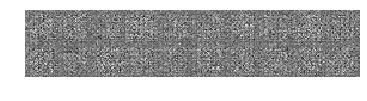

In [0]:
generated_data_to_visualize = tfgan.eval.image_reshaper(
    generated_samples[:20], num_cols=10)
visualize_digits(generated_data_to_visualize)

Training step: 0
Time since start: 25254580.674825 m
Steps per min: 0.000000


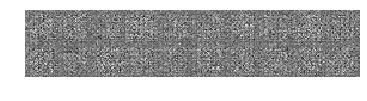

In [0]:
import time
generated_data_to_visualize = tfgan.eval.image_reshaper(
    generated_samples[:20], num_cols=10)
visualize_training_generator(0, 0, generated_data_to_visualize)

### Discriminator

In [0]:
class Discriminator(tfe.Network):
  def __init__(self, data_format):
    super(Discriminator, self).__init__()
    
    if data_format == 'channels_first':
      self._input_shape = [-1, 1, 28, 28]
    else:
      assert data_format == 'channels_last'
      self._input_shape = [-1, 28, 28, 1]
    
    self.conv1 = self.track_layer(tf.layers.Conv2D(64, 5, padding='SAME',
                                                   data_format=data_format,
                                                   activation=leaky_relu))
    #self.conv1_bn = self.track_layer(tf.layers.BatchNormalization())
    #self.pool1 = self.track_layer(
    #    tf.layers.AveragePooling2D(2, 2, data_format=data_format))
    
    self.conv2 = self.track_layer(tf.layers.Conv2D(128, 5,
                                                   data_format=data_format,
                                                   activation=leaky_relu))
    #self.conv2_bn = self.track_layer(tf.layers.BatchNormalization())
    #self.pool2 = self.track_layer(
    #    tf.layers.AveragePooling2D(2, 2, data_format=data_format))
    
    self.flatten = self.track_layer(tf.layers.Flatten())
    
    self.fc1 = self.track_layer(tf.layers.Dense(1024, activation=leaky_relu))
    self.fc2 = self.track_layer(tf.layers.Dense(1, activation=None))
  
  def call(self, inputs, training=True):
    """Actually runs the model."""
    x = tf.reshape(inputs, self._input_shape)
    x = self.conv1(x)
    #x = self.conv1_bn(x, training=training)
    #x = self.pool1(x)
    
    x = self.conv2(x)
    #if training:
    #  x = self.conv2_bn(x, training=training)
    #x = self.pool2(x)
    
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

Let's instantiate a discriminator:

In [0]:
D = Discriminator(data_format)

Initialize dimensions of variables etc:

In [0]:
D(generated_samples)

<tf.Tensor: id=362, shape=(32, 1), dtype=float32, numpy=
array([[  3.15277465e-03],
       [ -9.50451707e-04],
       [ -3.56810819e-03],
       [ -1.01500354e-03],
       [ -1.60333002e-04],
       [  3.80192912e-04],
       [  4.85292985e-04],
       [ -3.58096207e-04],
       [  8.67667142e-04],
       [ -2.37630075e-03],
       [ -3.00575746e-03],
       [  2.30062054e-04],
       [ -3.93919181e-05],
       [  5.26490097e-04],
       [ -6.47032051e-04],
       [ -3.49767320e-03],
       [ -2.90898304e-03],
       [ -1.55489065e-03],
       [ -2.40269746e-03],
       [ -3.67587927e-04],
       [ -3.73898214e-03],
       [ -1.24573847e-03],
       [  7.31731183e-04],
       [ -1.37241452e-03],
       [ -5.43178711e-03],
       [ -8.66755552e-04],
       [ -4.35060589e-03],
       [  2.54381215e-04],
       [  1.14134944e-03],
       [ -2.54764833e-04],
       [ -6.78511336e-03],
       [ -2.82252440e-05]], dtype=float32)>

## GAN workout

### Define losses...

In [0]:
def discriminator_loss(D, G, x, noise):
  D_real_logit = D(x)
  generated_images = G(noise)
  D_fake_logit = D(generated_images)
  #dis_loss = tfgan.losses.wargs.wasserstein_discriminator_loss(D_real_logit, D_fake_logit)
  dis_loss = tfgan.losses.wargs.minimax_discriminator_loss(D_real_logit, D_fake_logit)
  #gp_loss = tfgan.losses.wargs.wasserstein_gradient_penalty(x, generated_data, z, D, None) ### add args
  #gradient_penalty_weight = 1
  #dis_loss += gradient_penalty_weight * gp_loss
  return dis_loss

In [0]:
def generator_loss(D, G, noise):
  D_fake_logit = D(G(noise))
  gen_loss = tfgan.losses.wargs.minimax_generator_loss(D_fake_logit)
  return gen_loss

### ...and optimizers

In [0]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
# Weight clipping by 0.01 as per https://arxiv.org/pdf/1701.07875.pdf
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
#discriminator_optimizer = tfgan.features.clip_variables(discriminator_optimizer, D.trainable_variables, 0.01)

### Train step function

In [0]:
loss_values = []
def train_on_all_data(log_interval=100, disc_steps_per_gen_step=1):
  total_generator_loss = 0.0
  total_discriminator_loss = 0.0
  
  import time
  start_time = time.time()
  
  global_step = tf.train.get_or_create_global_step()
  
  for (batch_index, images) in enumerate(tfe.Iterator(dataset)):
    with tf.device('/cpu:0'):
      tf.assign_add(tf.train.get_global_step(), 1)

    #with tf.contrib.summary.record_summaries_every_n_global_steps(log_interval):
    current_batch_size = images.shape[0]
    noise_dim = 100
    noise = tf.random_uniform(shape=[current_batch_size, noise_dim],
                              minval=-1., maxval=1., seed=batch_index)
    
    # Train discriminator.
    for i in range(disc_steps_per_gen_step):

      ## 3) Compute all partial derivatives of the loss function,

      disc_loss, grads_and_vars = tfe.implicit_value_and_gradients(
          discriminator_loss
      )(D, G, images, noise)
      total_discriminator_loss += disc_loss

      ## 4) Optimize discriminator, and not generator (!).
      discriminator_grads_and_vars = [gv for gv in grads_and_vars if gv[1] in D.trainable_variables]
      discriminator_optimizer.apply_gradients(discriminator_grads_and_vars, global_step=global_step)

    # Train generator.  
    ## 2) Compute all partial derivatives of the loss function
    gen_loss, grads_and_vars = tfe.implicit_value_and_gradients(
        generator_loss
    )(
        D, G, noise
    )
    total_generator_loss += gen_loss

    ## 3) Optimize generator, and not discriminator (!)
    generator_grads_and_vars = [gv for gv in grads_and_vars if gv[1] in G.trainable_variables]
    generator_optimizer.apply_gradients(generator_grads_and_vars, global_step=global_step)

    cur_loss = disc_loss + gen_loss
    loss_values.append((batch_index, cur_loss))

    if batch_index % log_interval == 0:
      print('Batch #%d\tAverage Generator Loss: %.6f\t'
              'Average Discriminator Loss: %.6f' % (
                  batch_index, total_generator_loss/batch_index,
                  total_discriminator_loss/batch_index))
      print('Current loss: %f' % cur_loss)
      ## Update plot
      generated_data_to_visualize = tfgan.eval.image_reshaper(
        tf.reshape(G(noise, training=False), [-1, 28, 28, 1])[:20], num_cols=10)
      visualize_training_generator(batch_index, start_time, generated_data_to_visualize)
      display.display(plt.gcf())
      display.clear_output(wait=True)

  # Make sure only one plot remains in the output of this cell.
  %matplotlib inline

### Let's make our model sweat

In [29]:
tf.train.get_or_create_global_step()

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=1571>

In [26]:
checkpoint_dir = '/tmp/tensorflow/mnist/checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
latest_cpkt = tf.train.latest_checkpoint(checkpoint_dir)
if latest_cpkt:
  print('Using latest checkpoint at ' + latest_cpkt)

with tfe.restore_variables_on_create(latest_cpkt):
  train_on_all_data(log_interval=1, disc_steps_per_gen_step=1)

KeyboardInterrupt: ignored

In [34]:
import os
checkpoint_dir = '/tmp/tensorflow/mnist/checkpoints/'
if not tf.gfile.Exists(checkpoint_dir):
    tf.gfile.MakeDirs(checkpoint_dir)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
all_variables = (
        G.trainable_variables
        + D.trainable_variables)
        #+ generator_optimizer.variables()
        #+ discriminator_optimizer.variables()
        #+ [tf.train.get_or_create_global_step()])
tfe.Saver(all_variables).save(
    checkpoint_prefix, global_step=tf.train.get_or_create_global_step())

'/tmp/tensorflow/mnist/checkpoints/ckpt-1571'

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [47]:
# Upload the file to Drive. See:
#
# https://developers.google.com/drive/v3/reference/files/create
# https://developers.google.com/drive/v3/web/manage-uploads
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'Checkpoint MNIST DCGAN',
#  'mimeType': 'text/plain'
}
media = MediaFileUpload('/tmp/tensorflow/mnist/checkpoints/ckpt-1571.data-00000-of-00001', 
#                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 10IBPabOadHjgDEST_OQY93tO7nK02l-V


In [48]:
file_metadata = {
  'name': 'ckpt-1571.index',
#  'mimeType': 'text/plain'
}
media = MediaFileUpload('/tmp/tensorflow/mnist/checkpoints/ckpt-1571.index', 
#                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 116Zq9QJYXu82PwWvUZieKSD06CmO_0XR


In [49]:
file_metadata = {
  'name': 'checkpoint',
#  'mimeType': 'text/plain'
}
media = MediaFileUpload('/tmp/tensorflow/mnist/checkpoints/checkpoint', 
#                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1hCVchCeEwoIcQ5kkvPLiUfnZ9J0d5Xv1


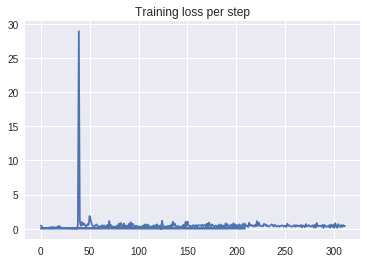

In [35]:
# Plot the eval metrics over time.
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))
plt.show()

## Generative adversarial network

### Ready, set, GO!

Some helpers for drawing samples from data and noise prior, respectively.

In [0]:
def sample_data(batch_size=200):
  x = np.random.normal(mean, variance, batch_size)
  x.sort()
  x = tf.constant(np.reshape(x, (batch_size, 1)))
  return x

def sample_noise_prior(batch_size=200):
  z = np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01
  z = tf.constant(np.reshape(z, (M, 1)))
  return z

Optimize generator and discriminator networks.

0.995


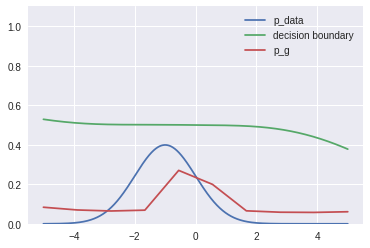

In [0]:
# Algorithm 1 of Goodfellow et al. (2014)

# Number of discriminator updates per epoch
k = 5
# Setup log of loss throughout training
histd, histg = np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)

for i in range(TRAIN_ITERS):
  # Train discriminator.
  for j in range(k):
    ## 1) Sample data,
    x = sample_data(batch_size=M)
    
    ## 2) Sample noise prior,
    z = sample_noise_prior(batch_size=M)

    ## 3) Compute all partial derivatives of the loss function,
    histd[i], grads_and_vars = tfe.implicit_value_and_gradients(neg_value_function)(D, G, x, z)
    
    ## 4) Optimize discriminator, and not generator (!).
    discriminator_grads_and_vars = [gv for gv in grads_and_vars if gv[1].name.startswith('D/')]
    discriminator_optimizer.apply_gradients(discriminator_grads_and_vars, global_step=batch)

  # Train generator.
  ## 1) Sample noise prior,
  z = sample_noise_prior(batch_size=M)
  
  ## 2) Compute all partial derivatives of the loss function
  histg[i], grads_and_vars = tfe.implicit_value_and_gradients(value_function)(D, G, x, z)
  
  ## 3) Optimize generator, and not discriminator (!)
  generator_grads_and_vars = [gv for gv in grads_and_vars if gv[1].name.startswith('G/')]
  opt_g.apply_gradients(generator_grads_and_vars, global_step=batch)

  # Illustrate current situation.
  if i % 100 == 0:
    print(float(i) / float(TRAIN_ITERS))
    
    ## Update plot
    plot_fig(D, G)
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Make sure only one plot remains in the output of this cell.
%matplotlib inline

As we can see in the plot above, the generator does a (reasonably) good job at outputting samples that resemble the data distribution. We can see that the discriminator outputs a value between 40% and 50%, as we'd expect at this point. The discriminator is unable to distinguish between a real and a generated sample.

Text(0.5,1,'History of loss throughout training')

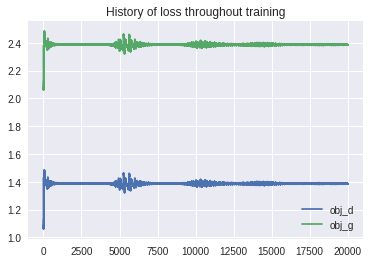

In [0]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1 - histg, label='obj_g')
plt.legend()
plt.title('History of loss throughout training')